# Alternative Classifier - XGBoost

In [1]:
import pandas as pd
import sys
import os
sys.path.append(os.getcwd()[:-18])
from source.eda_utils import get_dataFrame_withShortCols, data_cleaner, preprocess_data
from source.ml_utils import calculate_non_correlated_features, print_results, plot_roc
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
import xgboost as xgb

pd.options.mode.chained_assignment = None

In [2]:
# preprocessed data 
train_data = preprocess_data(data_cleaner(get_dataFrame_withShortCols('development_sample.csv')))
val_data = preprocess_data(data_cleaner(get_dataFrame_withShortCols('testing_sample.csv')))

In [3]:
selected_features = calculate_non_correlated_features(train_data, 0.60)

In [4]:
X_train, X_val = train_data[selected_features], val_data[selected_features]
y_train = train_data['Default indicator']
y_val = val_data['Default indicator']


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [5]:
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'merror',
    'eta': 0.05,  # Learning rate
    'max_depth': 5,  # Maximum depth of a tree
    'min_child_weight': 20,  # Minimum sum of instance weight (hessian) needed in a child
    'subsample': 0.8,  # Subsample ratio of the training instance
    'colsample_bytree': 0.8,  # Subsample ratio of columns when constructing each tree
    'scale_pos_weight': 35,  # Set class weights
    'gamma': 0,  # Minimum loss reduction required to make a further partition on a leaf node of the tree
    'lambda': 0,  # L2 regularization term on weights
    'alpha': 0,  # L1 regularization term on weights
    'seed': 42,  # Random seed
    'max_delta_step': 1,
}


dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dval = xgb.DMatrix(X_val_scaled)
xgb_model = xgb.train(params, dtrain)
y_pred_prob = xgb_model.predict(dval)
y_pred = (y_pred_prob > 0.5).astype(int)
print_results(y_val, y_pred)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)


Accuracy: 1.0
Confusion Matrix:
[[3427    0]
 [   0  119]]


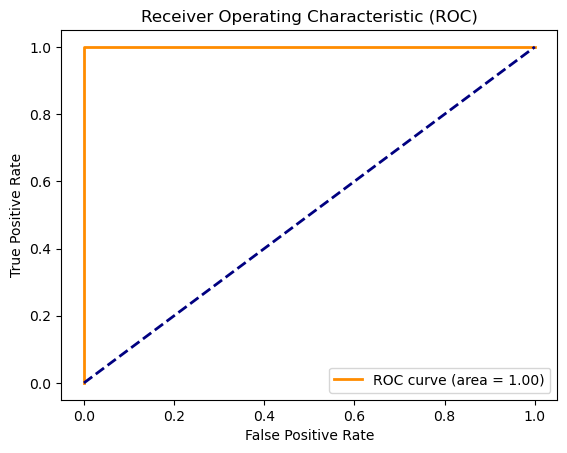

In [6]:
plot_roc(fpr, tpr)

c:\Users\mikol\anaconda3\envs\pre-selection\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[12:05:31] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "silent" } are not used.

Accuracy: 1.0
Confusion Matrix:
[[3427    0]
 [   0  119]]


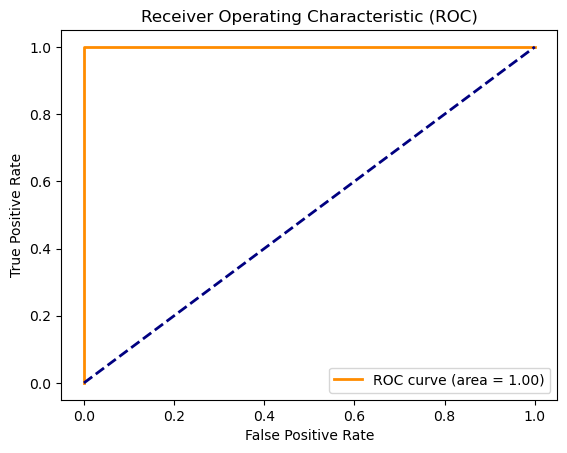

In [6]:
from sklearn.metrics import f1_score
import numpy as np

def f1_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    err = 1-f1_score(y_true, np.round(y_pred))
    return 'f1_err', err

clf_wine = xgb.XGBClassifier(max_depth=6, learning_rate=0.1,silent=False, objective='binary:logistic', \
                      booster='gbtree', n_jobs=8, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, \
                      subsample=0.8, colsample_bytree=0.8, colsample_bylevel=1, reg_alpha=0, reg_lambda=1)

# When you fit, add eval_metric=f1_eval
# Please don't forget to insert all the .fit arguments required
clf_wine.fit(X_train_scaled, y_train, eval_metric=f1_eval)

y_pred_prob = xgb_model.predict(dval)
y_pred = (y_pred_prob > 0.5).astype(int)
print_results(y_val, y_pred)


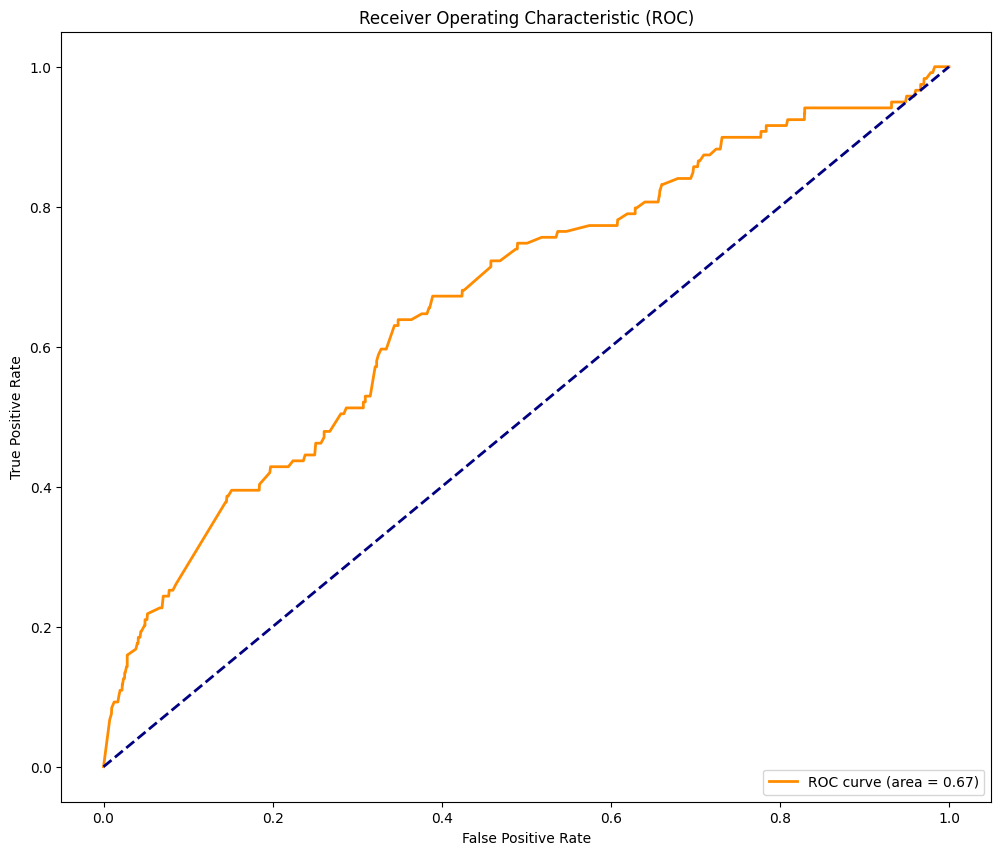

In [100]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
plot_roc(fpr, tpr)

In [101]:
#https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=pl#setup
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [102]:

#X_train_scaled, label=y_train

train_features = X_train_scaled
train_labels = y_train
METRICS = [
      #keras.metrics.TruePositives(name='tp'),
      #keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      #keras.metrics.R2Score(name = 'f1'),
      #keras.metrics.FalseNegatives(name='fn'), 
      #keras.metrics.BinaryAccuracy(name='accuracy'),
      #keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      #keras.metrics.AUC(name='auc'),
      #keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
        keras.layers.Dense(32, activation='sigmoid',
                         bias_initializer=output_bias),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [103]:
EPOCHS = 300
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

model = make_model()
model.summary()


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 16)                432       
                                                                 
 dense_37 (Dense)            (None, 32)                544       
                                                                 
 dropout_12 (Dropout)        (None, 32)                0         
                                                                 
 dense_38 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,009
Trainable params: 1,009
Non-trainable params: 0
_________________________________________________________________


In [104]:
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_val_scaled, y_val))


Epoch 1/300


18/18 [==============================] - 1s 17ms/step - loss: 1.3865 - tn: 2928.0000 - recall: 0.8913 - val_loss: 1.1272 - val_tn: 61.0000 - val_recall: 0.9748
Epoch 2/300
18/18 [==============================] - 0s 8ms/step - loss: 1.0408 - tn: 8802.0000 - recall: 0.7279 - val_loss: 0.8151 - val_tn: 870.0000 - val_recall: 0.7227
Epoch 3/300
18/18 [==============================] - 0s 8ms/step - loss: 0.7778 - tn: 16720.0000 - recall: 0.5050 - val_loss: 0.5885 - val_tn: 2412.0000 - val_recall: 0.3277
Epoch 4/300
18/18 [==============================] - 0s 6ms/step - loss: 0.5866 - tn: 23802.0000 - recall: 0.2922 - val_loss: 0.4347 - val_tn: 3394.0000 - val_recall: 0.0084
Epoch 5/300
18/18 [==============================] - 0s 6ms/step - loss: 0.4540 - tn: 28230.0000 - recall: 0.1744 - val_loss: 0.3340 - val_tn: 3427.0000 - val_recall: 0.0000e+00
Epoch 6/300
18/18 [==============================] - 0s 6ms/step - loss: 0.3640 - tn: 30888.0000 - recall: 0.1160 - val_loss: 0.2688 - val_tn:

2/2 [==============================] - 0s 0s/step
Accuracy: 0.9667230682459109
Confusion Matrix:
[[3427    0]
 [ 118    1]]


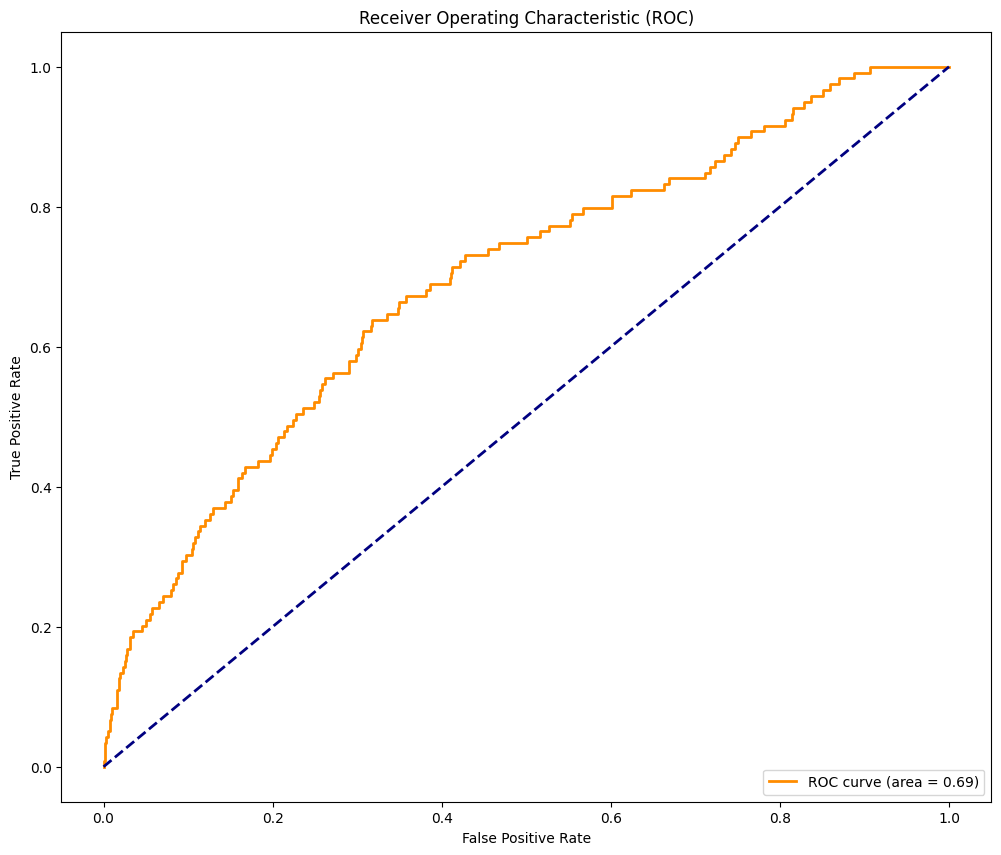

In [107]:
y_pred_prob = model.predict(X_val_scaled, batch_size=BATCH_SIZE)
y_pred = (y_pred_prob > 0.5).astype(int)
print_results(y_val, y_pred)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
plot_roc(fpr, tpr)